In [2]:
import sys
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from mpl_toolkits import mplot3d
from astropy import constants, units
from astropy.cosmology import WMAP9 as cosmo
from scipy import signal
from scipy.stats import binned_statistic_2d

import make_universe_2D #this makes 2Dslices
import make_universe_3D # this makes 3D cubes

import pspec_3D # computes pspecs of 3D cubes 
import pspec_2D # comptues pspecs of 2D slices 

import HERA_hack_FG
import FG_pygsm


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
plt.rcParams['mathtext.rm'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 20})

%load_ext autoreload
%autoreload 2

# 2D slice of a Gaussian Random Field

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


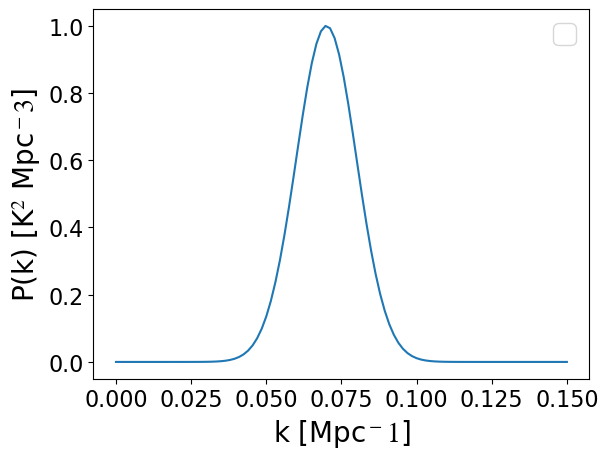

In [3]:
#number of pixels in each row and col
npix_row,npix_col = 50,50

#length and width of the box in Mpc
Lx = 325.5
Ly = 325.5
nbins = 30

def ps_gauss(x):
    mu, sigma = 0.07,0.01
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))
#      return np.sinc((x-0.1)*10)
x = np.linspace(0,0.15,100)
plt.plot(x,ps_gauss(x))
plt.ylabel(r"P(k) [K$^2$ Mpc$^-3$]")
plt.xlabel(r"k [Mpc$^-1$]")
plt.legend()


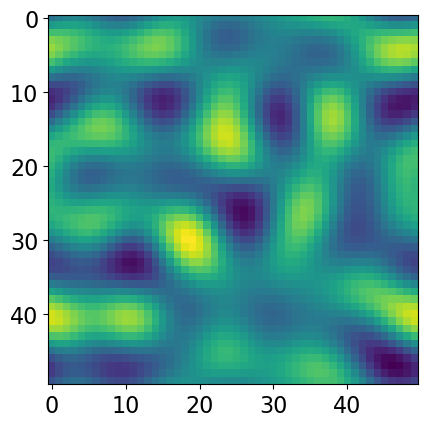

In [4]:
make_uni = make_universe_2D.universe(ps_gauss,npix_row,npix_col,Ly,Lx, mean = None)

uni = make_uni.make_2D_universe()

plt.imshow(uni)

(0.0, 0.1)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


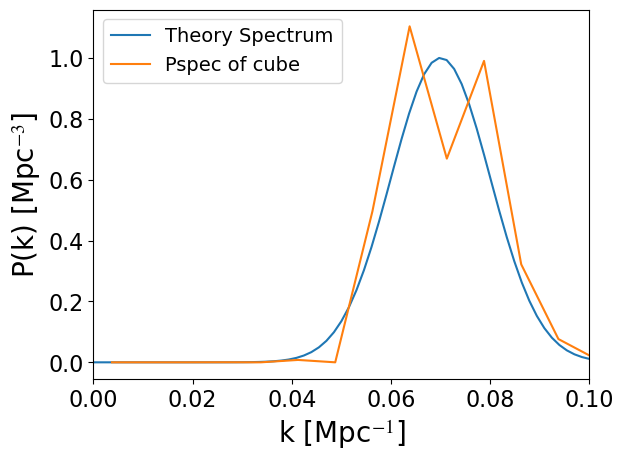

In [5]:
# now you can compute the pspec of this field to make sure
# that you get out what you put in 

pspec_2d = pspec_2D.Power_Spectrum(data = uni,Lx = Lx,Ly = Ly,nbins = 20,kmax = 0.15)

k , pspec = pspec_2d.compute_pspec()

plt.plot(x,ps_gauss(x), label = 'Theory Spectrum')
plt.plot(k, pspec, label = 'Pspec of cube')
plt.ylabel(r"P(k) [Mpc$^{-3}$]")
plt.xlabel(r"k [Mpc$^{-1}$]")
plt.legend(fontsize = 14)
plt.xlim(0,0.1)


# this obviously looks kinda wonky because of the binning which needs to be refined, but you get the jist.
# the pspec you put in is the pspec you get our (up to sample variance)

# Make 3D Gaussian random field

In [6]:
npix_row,npix_col, npix_aisle =50,50,50

#define frequency channels 
z_mid = 8
freq_mid = 1420/(1+z_mid)
pm_freq = 19.127/2
freqs = np.linspace(freq_mid-pm_freq, freq_mid+pm_freq,npix_aisle)

#Define the size of the box in Mpc (L) and then in rads (theta)
Lx = 325.5
theta_x = Lx/(cosmo.comoving_distance(z_mid).value)

Ly = 325.5
theta_y = Ly/(cosmo.comoving_distance(z_mid).value)

Lz = 325.49848672680474
nu = Lz/(((sc.c*((1+z_mid)**2))/(cosmo.H0.value*1000*(1.24e9)*cosmo.efunc(z_mid))))

#number of k bins
nbins = 30

Text(0.5, 0, 'k [Mpc$^{-1}$]')

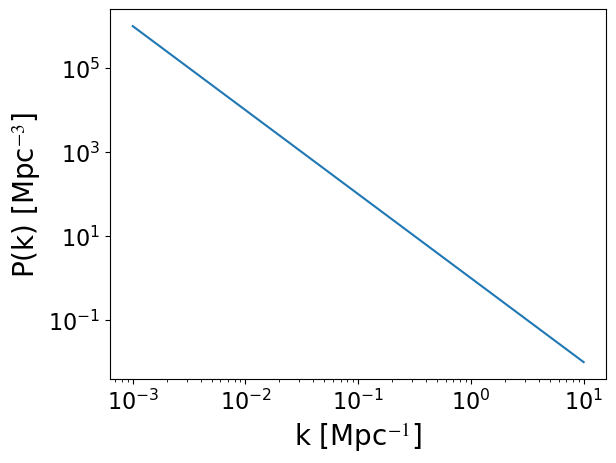

In [7]:
# random input spectrum
def ps(x):
    return x**(-2)

k = np.logspace(-3,1)
plt.loglog(k,ps(k))
plt.ylabel(r"P(k) [Mpc$^{-3}$]")
plt.xlabel(r"k [Mpc$^{-1}$]")

In [8]:
#make a lil universe
uni_3d = make_universe_3D.universe(ps_gauss,npix_row,npix_col,npix_aisle, Ly,Lx,Lz,nbins,z_mid = 8)
uni_3d.make_universe()


325.5 325.5 325.49848672680474


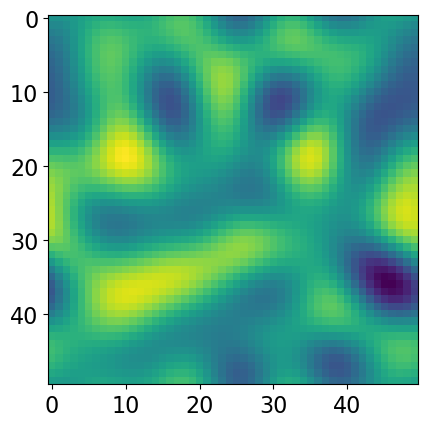

In [9]:
#Let's see a random freq slice 
plt.imshow(uni_3d.universe[1,:,:])

In [10]:
''' Compute 1d pspec of the cube. You can do this either by binning your Fourier cube in spherical shells directly
or, you can compute the 2D power spectrum and then bin in quarter annuli.
please keep in mind that the resulting power spectra will be slightly different due to the kperp binning step'''

pspec_3d = pspec_3D.Power_Spectrum(data = uni_3d.universe, theta_x=theta_x, theta_y = theta_y,
                                freqs = freqs*(1e6),rest_freq = 1420*(1e6),nbins = 30, nbins_perp = 60)

pspec_1d = pspec_3d.compute_1D_pspec()
pspec1d_from_2d = pspec_3d.compute_1d_from_2d()




(0.0, 0.15)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


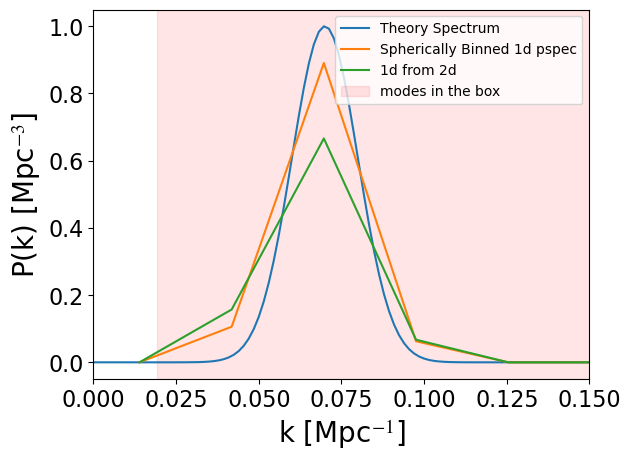

In [11]:
plt.plot(x,ps_gauss(x), label = 'Theory Spectrum')
plt.plot(pspec_1d[0], pspec_1d[1], label = 'Spherically Binned 1d pspec')
plt.plot(pspec1d_from_2d[0],pspec1d_from_2d[1], label = '1d from 2d')
plt.axvspan(2*np.pi/325.5,2*np.pi/(325.5/50), color = 'r', alpha = 0.1, label = 'modes in the box')
plt.ylabel(r"P(k) [Mpc$^{-3}$]")
plt.xlabel(r"k [Mpc$^{-1}$]")
plt.legend(fontsize = 10, loc = 'upper right')
plt.xlim(0,0.15)



In [12]:
#compute 2D pspec 
k_par, k_perp, pspec_2d = pspec_3d.compute_2D_pspec()

Text(0.5, 0, 'k$_{\\perp}$[Mpc$^{-1}]$')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


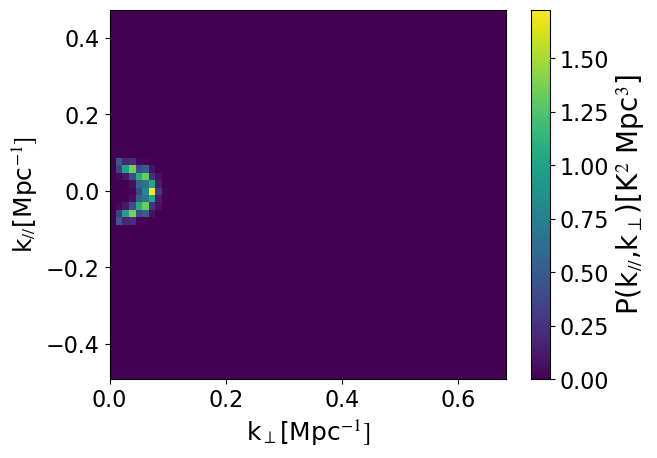

In [13]:
im = plt.pcolor(k_perp,k_par,pspec_2d,shading='auto')#, edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}$[Mpc$^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}$[Mpc$^{-1}]$', fontsize = 18)


# Generate Foregrounds

Here we'll generate some statistically accurate foregrounds meaning that for each pixel we're just draw from a power law distribution that is consistent with either synchrotron emission, free-free emission, or unresolved extragalactic point sources. 

In [14]:
#for this example I'm just generating a fake 
#telescope and observational scenario

dishes = np.array([[0,0],[150,75],[0,150],[0,-57.39295490174667],[30,0],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])

npix_row,npix_col = 50,50

pbeam = True 
norm = True 


acorner = np.array([[119,274],[121,276],[119,276],[121,274]])

my_fake_telescope = HERA_hack_FG.telescope(dishes, latitude=-30, channel_width=97800, beam_width=10, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = my_fake_telescope, n_days = 3, freq = 200, delta_t = 0.002 ,corners = acorner, beam_sigma_cutoff=10, sky_shape = (npix_row,npix_col), norm = norm , pbeam = pbeam)

unresolved_sources_per_pixel = 200

fg = FG_pygsm.foregrounds(obs)



Text(0.5, 1.0, 'Free-Free Emission @ 200MHz')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


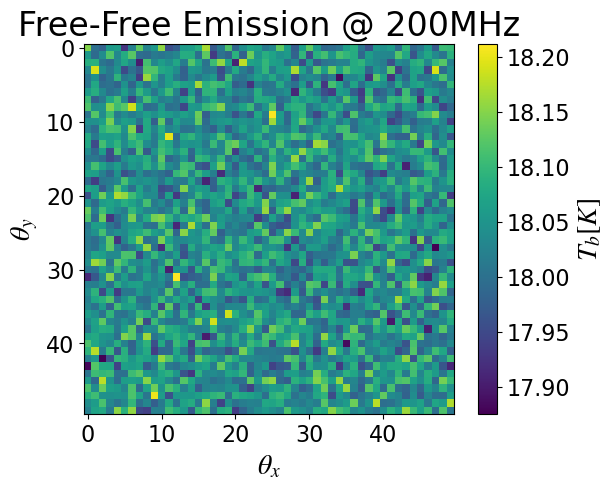

In [15]:
free_free = fg.compute_bremsstrauhlung()

plt.imshow(free_free.reshape(npix_row,npix_col))
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$')
plt.colorbar(label = r"$T_b [K]$")
plt.title('Free-Free Emission @ %sMHz'%fg.freq)


Text(0.5, 1.0, 'Unresolved Point Sources @ 200MHz')

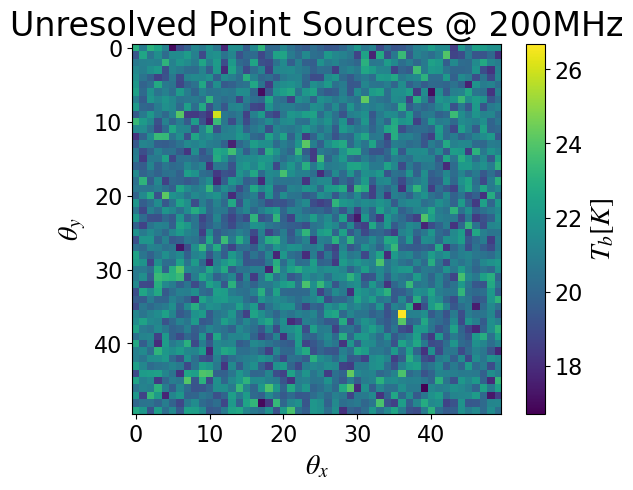

In [16]:
unres_psource = fg.compute_unres_point_sources(200)

plt.imshow(unres_psource.reshape(npix_row,npix_col))
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$')
plt.colorbar(label = r"$T_b [K]$")
plt.title('Unresolved Point Sources @ %sMHz'%fg.freq)


[153.2447653  144.41468693 152.41502941 ... 148.68305688 157.36863788
 147.09072171]


Text(0.5, 1.0, 'Synchrotron emission  @ 200MHz')

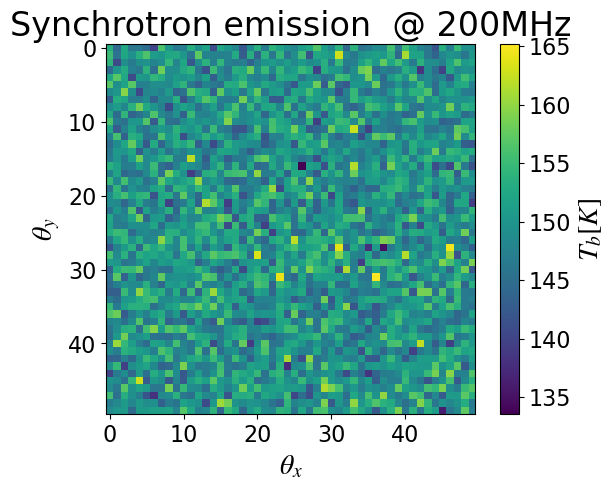

In [17]:

synchrotron = fg.compute_synchro()

print(synchrotron)
plt.imshow(synchrotron.reshape(npix_row,npix_col))
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$')
plt.colorbar(label = r"$T_b [K]$")
plt.title('Synchrotron emission  @ %sMHz'%fg.freq)


Putting that all together we get....

In [18]:
#Foreground map: synchrotron + freefree + unresolved point sources

diffuse_fg = fg.diffuse_fg(unresolved_sources_per_pixel,pygsm = False)


Text(0.5, 1.0, 'Total Diffuse Foregounds @ 200MHz')

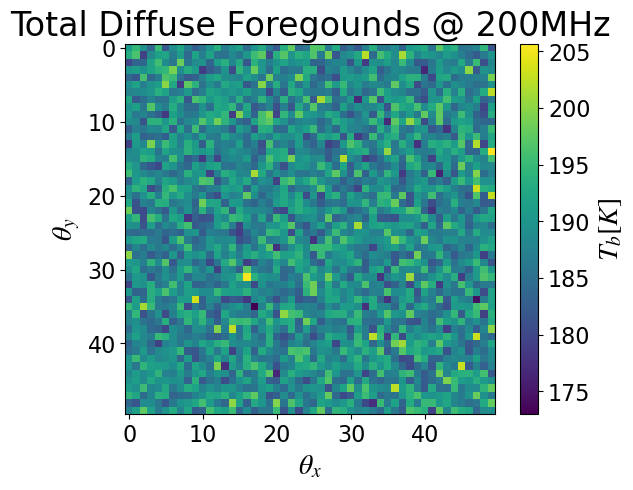

In [19]:
plt.imshow(diffuse_fg.reshape(npix_row,npix_col))
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$')
plt.colorbar(label = r"$T_b [K]$")
plt.title('Total Diffuse Foregounds @ %sMHz'%fg.freq)

If you want to use pydsgm foreground maps, then you just need to instatiate the foreground class then run diffuse_fg with pygdm = True

In [20]:
# path = '/Users/hannahfronenberg/Documents/GitHub/SKA_SDC3'

fg = FG_pygsm.foregrounds(obs)

diffuse_pygdsm = fg.diffuse_fg(unresolved_sources_per_pixel,pygsm = True)

Text(0.5, 1.0, 'Total Diffuse Foregounds w/ pygdsm @ 200MHz')

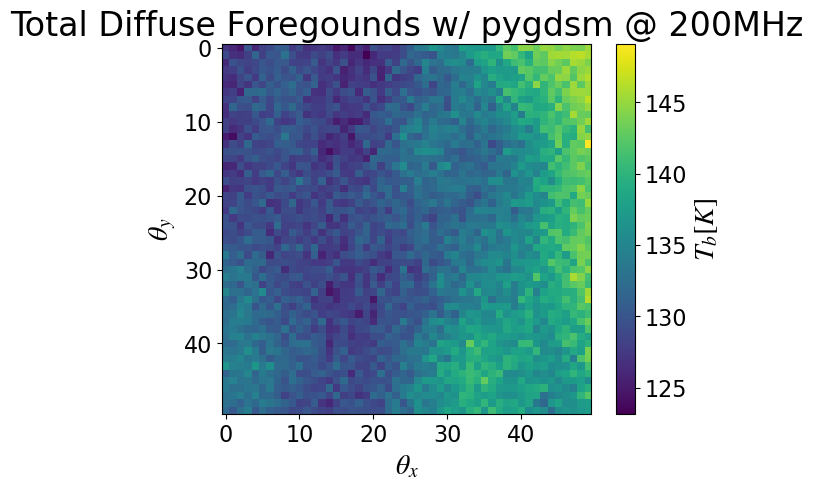

In [21]:
plt.imshow(diffuse_pygdsm.reshape(npix_row,npix_col))
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$')
plt.colorbar(label = r"$T_b [K]$")
plt.title('Total Diffuse Foregounds w/ pygdsm @ %sMHz'%fg.freq)

# here you can see that we capture the spatial structure of the foregrounds in addition to the spectral structure. 

# Extragalactic Point Sources 


1. Generate pyuvsim point sources

2. Grid it 

3. Convert to K

In [131]:
def mock_catalog(n_src, x_pix, y_pix, freqs, min_flux=0.1, max_flux=100, ref_freq=150e6, pix_area=1):
    """Make a mock catalog of point sources and bin to the desired resolution, in Jy/sr.
    
    Sources are randomly assigned spectral indices between -0.5 and -3, and spectral
    evolution is included according to the randomly assigned spectral indices.
    """
    x_bin_edges = np.arange(0, x_pix+1)
    y_bin_edges = np.arange(0, y_pix+1)
    x_pos = np.random.uniform(low=0, high=x_pix, size=n_src)
    y_pos = np.random.uniform(low=0, high=y_pix, size=n_src)
    src_flux = 10**np.random.uniform(
        low=np.log10(min_flux), high=np.log10(max_flux), size=n_src
    )
    spec_inds = np.random.uniform(low=-3, high=-0.5, size=n_src)
    stokes = src_flux[None,:] * (freqs[:,None]/ref_freq)**spec_inds[None,:]
    conversion = (units.Jy/units.sr).to(
        units.K, equivalencies=units.brightness_temperature(freqs*units.Hz)
    )[:,None,None]
    return binned_statistic_2d(
        x_pos, y_pos, stokes, bins=[x_bin_edges, y_bin_edges], statistic="sum"
    )[0] * conversion / pix_area

In [140]:
src_density = 300e3 / (2*np.pi)
survey_area = (9.1 * units.deg.to("rad"))**2
n_src = int(src_density * survey_area)
pix_area = (16 * units.arcsec.to("rad"))**2
freqs = np.linspace(140e6, 160e6, 20)
n_pix_per_side = 100

In [141]:
catalog = mock_catalog(n_src, n_pix_per_side, n_pix_per_side, freqs, pix_area=pix_area*(2048/n_pix_per_side)**2)

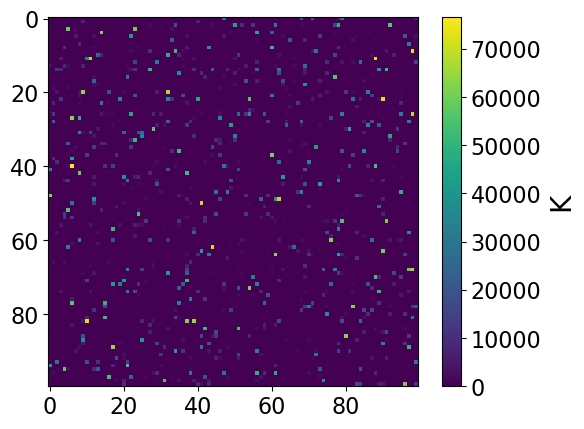

In [143]:
plt.imshow(catalog[0])
plt.colorbar(label="K")

# Total Sky 

In [ ]:
# signal + psource + diffuse_fg 

# Then apply SKA PSF

# Map-Making

Here we're going to simulate the sky imaged by an instrument. Here I've just invented a ranom interferomentric array (you can see the layout below in the plot titled "My Fake Array" lol) 

We start by generating visibilities and then deconvolve them using a pseudo-inverse least squares mapping estimator. I know that some of the MIT people have been working on direct optimal mapping estimators so maybe we want to play around with adding that later. 

Text(0.5, 1.0, 'My Fake Array')

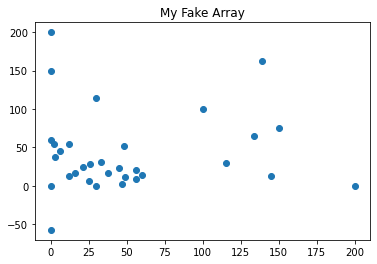

In [34]:
#this is the fake array that I made up, 
#obviously we'll put SKA instead of this but here this is just an example

plt.scatter(dishes[:,0],dishes[:,1])
plt.title('My Fake Array')

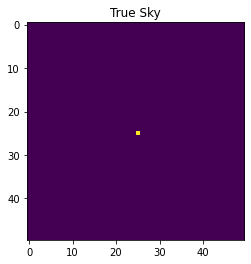

In [37]:
#Let's make our sky a point souce in the middle of the field.
psource_loc = int(2500/2 + 25)


sky = signal.unit_impulse(npix_row*npix_col, idx=psource_loc )#delta funtion point source in the middle
plt.imshow(np.reshape(sky,(50,50)))

plt.title('True Sky')
obs.convolve_map(sky,psource_data = None,psource_beam = None)

Text(0.5, 1.0, 'Observed Sky')

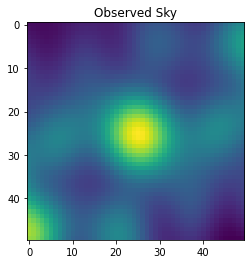

In [39]:

convolved_map = np.reshape(np.real(obs.map),(50,50))
plt.imshow(convolved_map)
plt.title('Observed Sky')